In [1]:
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import constants
import lightkurve as lk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

This notebook explores functions that can be used to extract TESS FFIs.

First, custom functions that use TESScut.

In [2]:
def get_TPF(ID:int, sector:int):
    """
    Queries TIC for a target star and returns its TPF.
    Args:
        ID (int): TIC ID of the target.
        sectors (numpy array): Sectors in which the target has been observed.
        search_radius (int): Number of pixels from the target star to search.
    Returns:
        TPF (numpy array): Time-series FFI of the target. 
        time (numpy array): Times corresponding to each image.
    """
    
    # find coordinates of the target
    df = Catalogs.query_object("TIC"+str(ID), radius=0.0001, catalog="TIC").to_pandas()
    target = df[["ID", "Tmag", "ra", "dec", "mass", "rad", "Teff", "logg", "lum", "plx"]]
    ra, dec = target["ra"].values, target["dec"].values
    # get the TPF with TESScut
    cutout_coord = SkyCoord(ra[0], dec[0], unit="deg")
    cutout_hdu = Tesscut.get_cutouts(cutout_coord, size=20, sector=sector)[0]
    TPF = cutout_hdu[1].data["Flux"]
    time = cutout_hdu[1].data["Time"]
    return TPF, time

def get_lightcurve(TPF:np.ndarray, aperture:np.ndarray, subtract_background:bool = True):
    """
    Converts a target's FFIs into a light curve given an aperture and performs a simple background subtraction.
    Args:
        TPF (numpy array): Target Pixel File (time-series FFI) of the target. 
        aperture (numpy array): Aperture mask used to extract the light curve.
        subract_background (bool): Whether or not to do background subtraction.
    Returns:
        flux (numpy array): Extracted light curve flux.
    """
    
    if subtract_background == True:
        # calculate the background for each image by taking the median pixel flux outside of the aperture
        background = np.median(TPF[:,~aperture], axis=1)
        # calculate the flux by summing the values in the aperture pixels and subtracting the background
        n_aperture_pixels = aperture[aperture==True].flatten().shape[0]
        flux = np.sum(TPF[:,aperture], axis=1) - background * n_aperture_pixels
    else:
        # calculate the flux by summing the values in the aperture pixels
        flux = np.sum(TPF[:,aperture], axis=1)
    return flux

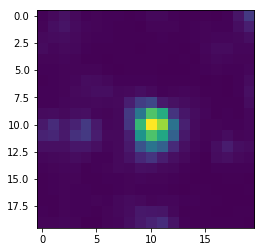

In [3]:
# get the FFIs and plot the first one
TPF, time = get_TPF(ID=201292545, sector=2)
plt.imshow(np.log10(TPF[0]));

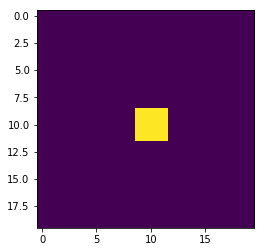

In [4]:
# define an aperture
mask = np.zeros(TPF.shape[1:], dtype=bool)
mask[9:12,9:12] = True
plt.imshow(mask);

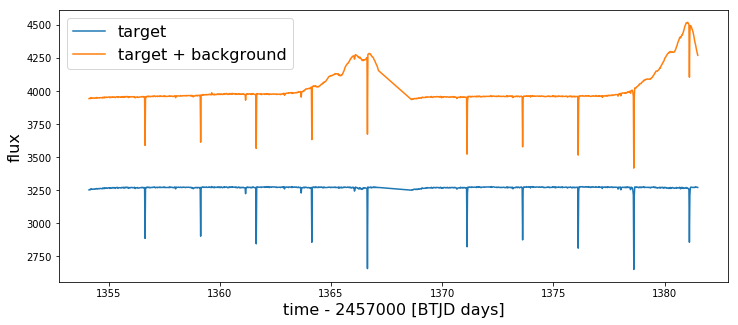

In [5]:
# extract the flux from the TPF + aperture and compare 
flux = get_lightcurve(TPF=TPF, aperture=mask)
flux_with_background = get_lightcurve(TPF=TPF, aperture=mask, subtract_background=False)

plt.figure(figsize=(12,5))
plt.plot(time, flux, label="target");
plt.plot(time, flux_with_background, label="target + background");
plt.xlabel("time - 2457000 [BTJD days]", fontsize=16)
plt.ylabel("flux", fontsize=16)
plt.legend(loc=2, fontsize=16);

Lightkurve also has some useful tools for doing this. Let's take a look at those. (source: https://docs.lightkurve.org/tutorials/03-cutting-out-tpfs-from-tess-ffis.html)

In [2]:
# search for the target on MAST and extract the TPF
search_result = lk.search_tesscut('TIC201292545', sector=2)
tpf = search_result.download(cutout_size=20)

In [84]:
# create a aperture using their .create_threshold_mask method
target_mask = tpf.create_threshold_mask(threshold=15, reference_pixel='center')
n_target_pixels = target_mask.sum()
print(n_target_pixels)

18


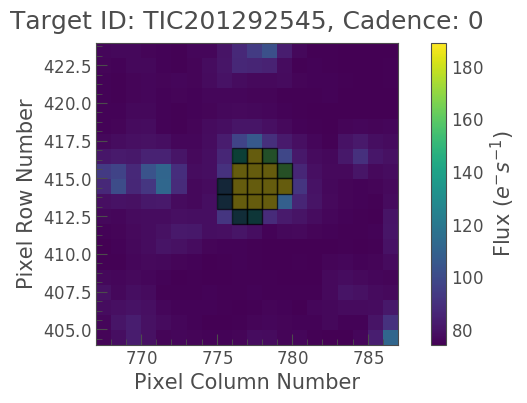

In [85]:
# plot an image with the chosen aperture
tpf.plot(aperture_mask=target_mask, mask_color='k');

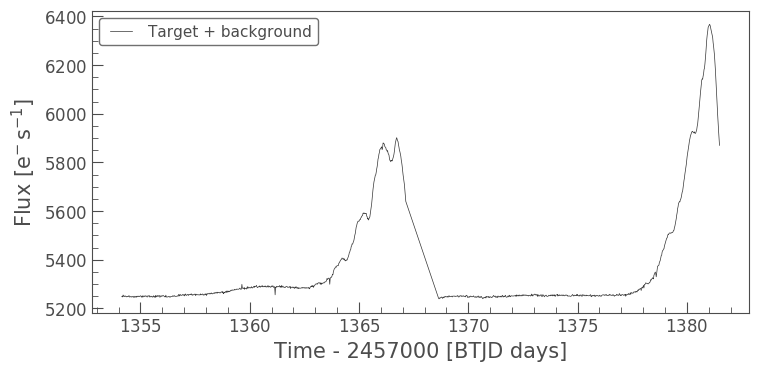

In [86]:
# extract the light curve using the aperture
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)
target_lc.plot(label='Target + background');

200


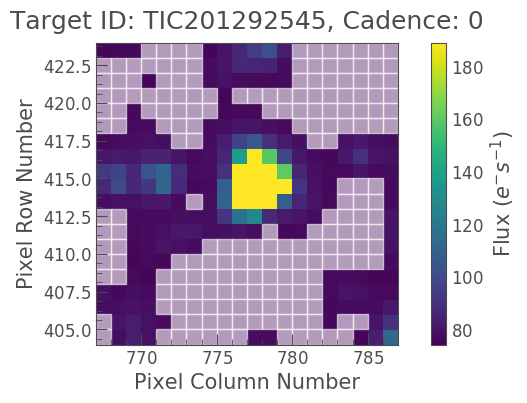

In [87]:
# estimate a background mask to subtract it out
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
n_background_pixels = background_mask.sum()
print(n_background_pixels)
tpf.plot(aperture_mask=background_mask, mask_color='w');

In [88]:
# calculate background as mean flux in background mask pixels
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
# background in aperture is then that mean value times the number of aperture pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels

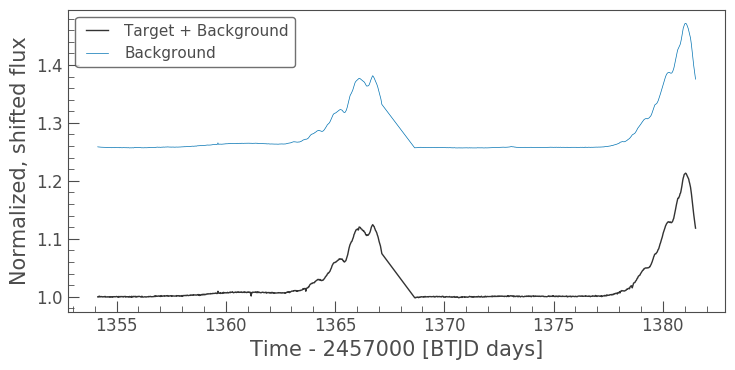

In [89]:
# compare backgound + target with just background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');

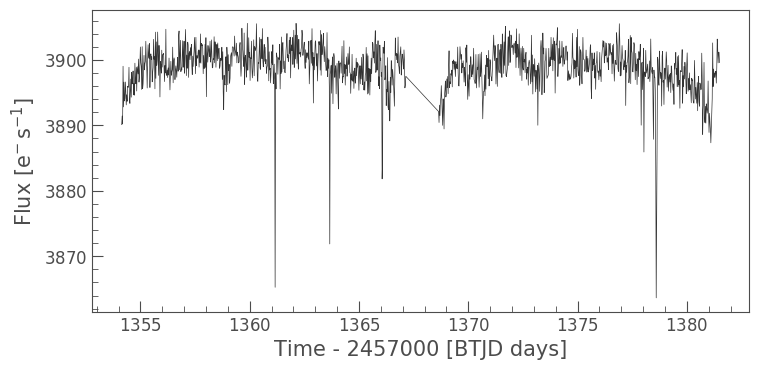

In [90]:
# subtract the background and plot corrected light curve
corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot();